In [15]:
#-- IMPORTING MODULES --
import numpy as np
import mpmath as mp

import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import fsolve
import scipy.misc
from scipy.misc import derivative
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.integrate import quad, trapz, cumtrapz, romberg, fixed_quad, odeint, ode
from scipy import linalg
from numpy.linalg import inv
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
import time

#Atropy cosmology modules
import astropy.units as astrou
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from astropy.cosmology import z_at_value
from astropy.table import Table, Column, MaskedColumn

# Import mycode
import sys
path = '/Users/feixu/OneDrive - The University of Chicago/Documents/Research'
sys.path.append(path+'/mycode/')
sys.path.append(path+'/lensingFei/')
import gwfei
import constantfei 
from optical_depthfei import *
from RBBH_fei import *


#Plotting
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

#Export results folder
import sys
dir_base=sys.path[0]
dir_out1=dir_base+"/plots_py_gw_lensing/"
dir_out2=dir_base+"/fits_py_gw_lensing/"

In [16]:
# Read in Mchirp, q distribution generated from ITM (See P(Mchirp, q) 2D interpolation.ipynb)
hdul = fits.open('/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/github/fits_py_gw_lensing/Pchirpq_2Dfei.fits')
data1 = hdul[1].data
mchirp_2d = data1['mchirp_2d']
qratio_2d = data1['qratio_2d']
pdf_2d = data1['pdf_2d']

splchirpq = interpolate.interp2d(mchirp_2d, qratio_2d, pdf_2d, kind='linear', fill_value=0)

# Interpolate to get the 2D function
def Pchirpq_2d(mchirp, qratio):
    return splchirpq(mchirp, qratio)

Pchirpq_2d = np.vectorize(Pchirpq_2d)

-6.907755278982137 4.605170185988092
1.0279432843001153


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  del sys.path[0]
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

0.9999999999999997


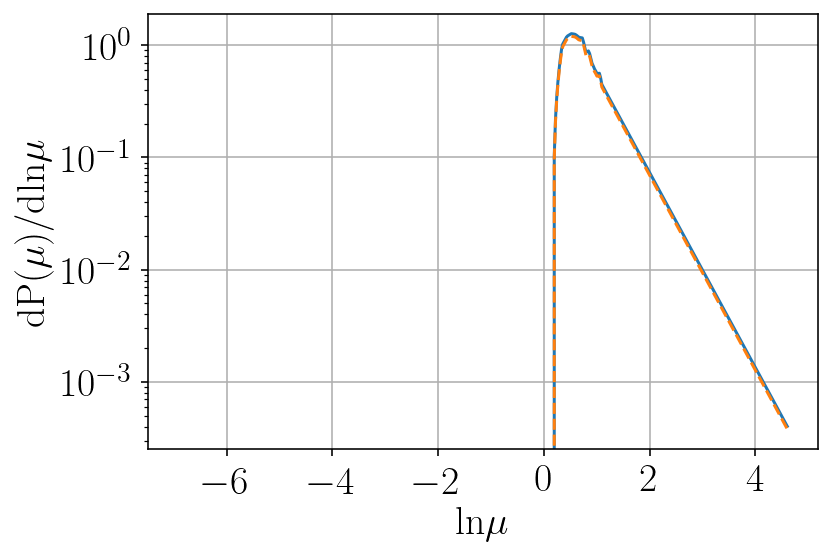

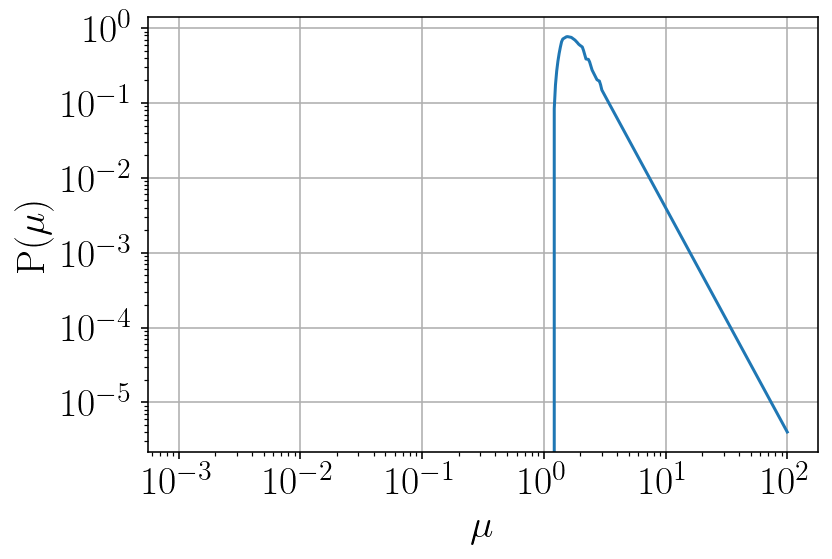

In [17]:
hdul = fits.open(dir_out2+'Pmu1_fitting.fits')
data1 = hdul[1].data
mu_1st = data1['mul']
Pmu_1stl = data1['Pmu1_fitting(mul)']

lgmu_min = np.min(np.log(mu_1st)); lgmu_max = np.max(np.log(mu_1st))
print(lgmu_min, lgmu_max)

lgmul = np.log(mu_1st)

#print(len(mu_1st), len(Pmu_1stl))
spllgMU = interpolate.interp1d(lgmul, Pmu_1stl*mu_1st, kind='linear', fill_value='extrapolate')
area = integrate.quad(lambda x: spllgMU(x), lgmu_min, lgmu_max)[0]
print(area)

def Plgmu_1st(lgmu0):
   
    if (spllgMU(lgmu0) >0.):
        value = spllgMU(lgmu0)
    else:
        value = 0.
        
    return value/area

Plgmu_1st = np.vectorize(Plgmu_1st)

plt.plot(lgmul, Pmu_1stl*mu_1st)
plt.plot(lgmul, Plgmu_1st(lgmul)/area, '--')
#Pmu_1st(mul)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'ln$\mu$', fontsize=20)
plt.ylabel(r'dP($\mu$)/dln$\mu$', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

print(integrate.quad(lambda x: Plgmu_1st(x), lgmu_min, lgmu_max)[0])

plt.figure()
plt.plot(mu_1st, Pmu_1stl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\mu$', fontsize=20)
plt.ylabel(r'P($\mu$)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)


In [18]:
hdul = fits.open(dir_out2+'fractz_mchirpqratio.fits')
data1 = hdul[1].data
MCHIRPL_aligo = data1['MCHIRPL']
QRATIOL_aligo = data1['QRATIOL']


In [19]:
hdul = fits.open(dir_out2+'fractz_aligo_snrcorrect.fits')
data1 = hdul[1].data
zl_aligo = data1['zl_aligo']
rhooptl_aligo = data1['rhooptl_aligo']
fractz_aligo = data1['fractz_aligo']

mchirpl = np.linspace(1, 50., num=90); 
qratiol = np.linspace(0, 1., num=80); 
lgmul = np.linspace(lgmu_min, lgmu_max, num=90)

ZL, MCHIRPL, QRATIOL, LGMUL = np.meshgrid(zl_aligo, mchirpl, qratiol, lgmul, indexing='ij', sparse=True)


In [20]:
def rhoopt_find_aligo(z0, mchirp, qratio):
    ind0x = np.where(z0 == zl_aligo)
    #print(ind0x)
    ind0y = np.where((MCHIRPL_aligo == mchirp)*(QRATIOL_aligo == qratio))
    #print(ind0y)
    return rhooptl_aligo[ind0x][0][ind0y][0]
rhoopt_find_aligo = np.vectorize(rhoopt_find_aligo)

In [21]:
start = time.time()
TEMP0 = rhoopt_find_aligo(ZL, MCHIRPL, QRATIOL)
end = time.time()
print(end-start)

26.147637128829956


In [22]:
def P_detect(rho_given):

    
    # For 1 detector
    a2 = 0.374222; a4 = 2.04216; a8 = -2.63948
    
    if (rho_given <8.): # Must not be integer 8->8.
        value = 0.
    else:
        w = rho_th/rho_given
        value = a2*(1-w)**2+a4*(1-w)**4+a8*(1-w)**8+(1-a2-a4-a8)*(1-w)**10
    
    return value

P_detect = np.vectorize(P_detect)

In [23]:
start = time.time()
TEMP = Pchirpq_2d(MCHIRPL, QRATIOL)*Plgmu_1st(LGMUL)*P_detect(np.sqrt(10**LGMUL)*TEMP0)
end = time.time()
print(end-start)

19.55615520477295


In [24]:
fractzl_mag1_aligo = []
for i in range(len(zl_aligo)): 
    
    fractzl_mag1_aligo.append(np.sum(TEMP[i]*(mchirpl[1]-mchirpl[0])*(qratiol[1]-qratiol[0])*(lgmul[1]-lgmul[0])))
    
    

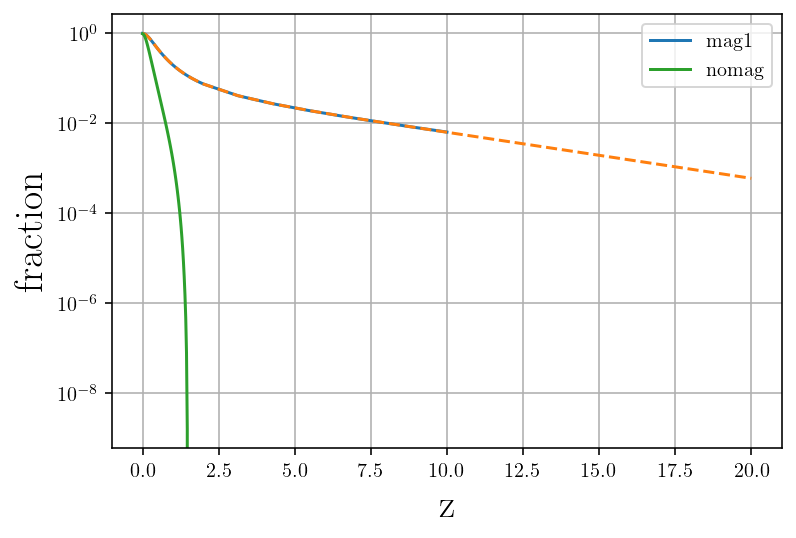

In [25]:
plt.plot(zl_aligo, np.array(fractzl_mag1_aligo), label='mag1')
spl = interpolate.interp1d(zl_aligo[np.where(zl_aligo <10)], np.log10(np.array(fractzl_mag1_aligo))[np.where(zl_aligo <10)], kind='linear', fill_value='extrapolate')
plt.plot(np.linspace(0, 20, num=200), 10**spl(np.linspace(0, 20, num=200)), '--')
#plt.plot(zl_aligo, fractz_aligo)
plt.plot(zl_aligo, fractz_aligo, label='nomag')
#plt.plot(zl_aligo, tau_spec(zl_aligo,161e3)*1e2, label=r'$\tau(z)*1e3$')
plt.xlabel('z', fontsize=20)
plt.ylabel('fraction', fontsize=20)
#plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()

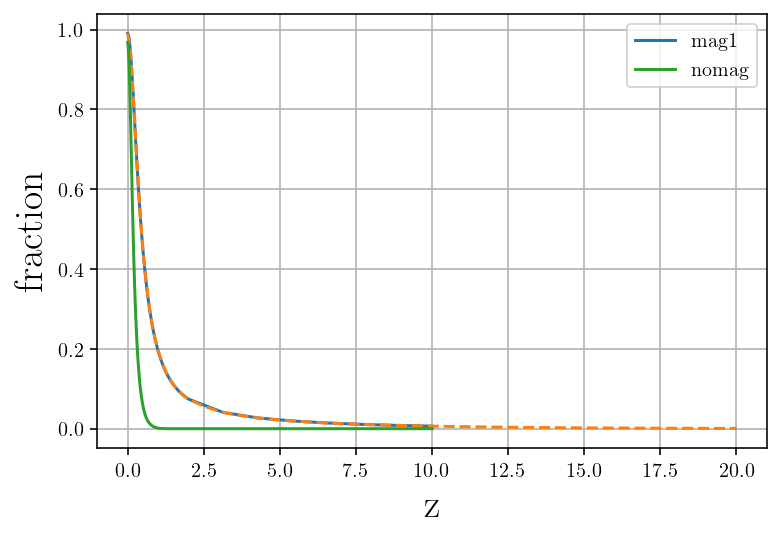

In [26]:
plt.plot(zl_aligo, np.array(fractzl_mag1_aligo), label='mag1')
spl = interpolate.interp1d(zl_aligo, np.log10(np.array(fractzl_mag1_aligo)), kind='linear', fill_value='extrapolate')
plt.plot(np.linspace(0, 20, num=200), 10**spl(np.linspace(0, 20, num=200)), '--')
#plt.plot(zl_aligo, fractz_aligo)
plt.plot(zl_aligo, fractz_aligo, label='nomag')
#plt.plot(zl_aligo, tau_spec(zl_aligo,161e3)*1e2, label=r'$\tau(z)*1e3$')
plt.xlabel('z', fontsize=20)
plt.ylabel('fraction', fontsize=20)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True)
plt.legend()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


(10.927839377830662, 0.0003487181726971045)

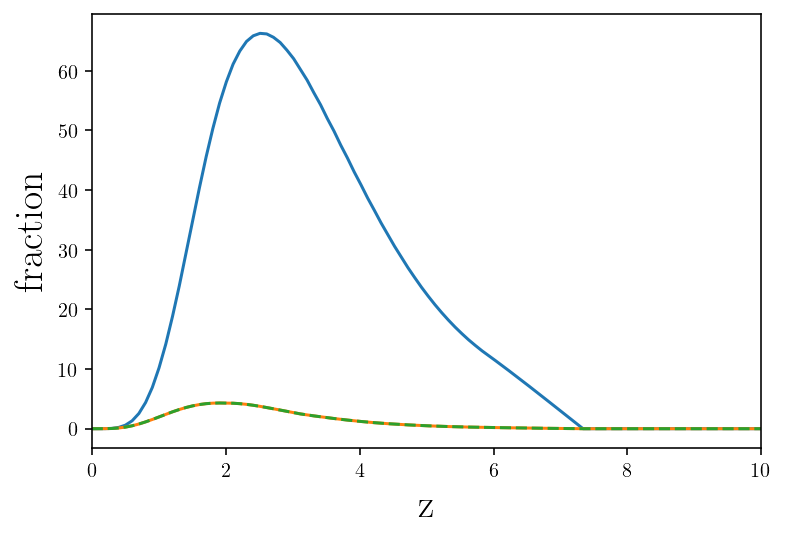

In [27]:
zl = np.linspace(0, 20, num=200)
def fractest(z):
    if (10**spl(z) >= 0.):
        value= 10**spl(z)
    else:
        value = 0
    return value
fractest = np.vectorize(fractest)
plt.plot(zl, dR_dz_orgv(zl)*tau_spec(zl,161e3))
plt.plot(zl, dR_dz_orgv(zl)*fractest(zl)*tau_spec(zl,161e3))
spltest = interpolate.interp1d(zl, dR_dz_orgv(zl)*fractest(zl)*tau_spec(zl,161e3), kind='linear', fill_value='extrapolate')
plt.plot(zl, spltest(zl), '--')
plt.xlabel('z', fontsize=20)
plt.ylabel('fraction', fontsize=20)
plt.xlim(0,10)

plt.xticks()

integrate.quad(lambda x: spltest(x), 0, 20)

In [13]:
t = Table([zl_aligo, np.array(fractzl_mag1_aligo)], \
              names=['zl_aligo', 'fractz_aligo_mag1'], masked=True)
t.write(dir_out2+'fractz_aligo_mag1.fits', format='fits', overwrite=True) 


In [29]:
integrate.quad(lambda x: dR_dz_orgv(x)*fractfun_aligo_mag1(x)*tau_spec(x,161e3), 0, 100)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


(10.929494722958488, 9.567627556883451e-05)